# The Data Driven Newsvendor

The newsvendor problem is the classical single period inventory problem that refers to a situation in which a seller (the newsvendor) has to determine the order quantity of perishable goods for the next selling period under uncertainty in demand. The traditional way to solve the problem assumes that the demand distribution is known. In practice, however, we almost never know the true demand distribution. 

In the following tutorial, you will get to know different approaches to solve the newsvendor problem when the underlying demand distribution is unknown but the decision maker has access to past demand observations. In this context, we consider the decision problem of Yaz, a fast-casual restaurant in Stuttgart. In addition, you will learn how to apply these approaches using our Python library `ddop`.

## Getting started

Before jumping into the tutorial, you should know the basics of Python and be familiar with well known libraries like numpy, pandas, and scikit-learn. To execute code, make sure you have an empty Python virtual environment installed on your computer.

In [1]:
pip install ddop==0.6.3 seaborn==0.10.1 matplotlib

In [2]:
from ddop.metrics import average_costs
from ddop.newsvendor import SampleAverageApproximationNewsvendor
from ddop.newsvendor import DecisionTreeWeightedNewsvendor
from ddop.newsvendor import KNeighborsWeightedNewsvendor
from ddop.newsvendor import LinearRegressionNewsvendor
from ddop.newsvendor import DeepLearningNewsvendor
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Using TensorFlow backend.


## The Newsvendor Problem at Yaz

Let us now start by introducing the decision problem at Yaz. Yaz is a fast casual restaurant in Stuttgart providing great oriental cuisine. The main ingredients for the meals, such as steak, lamb, fish, etc., are prepared at a central factory and are deep-frozen to achieve longer shelf lives. Depending on the estimated demand for the next day, the restaurant manager has to decide how much of the ingredients to defrost over night. These defrosted ingredients/meals then have to be sold within the following day. If the defrosted quantity was too low, each unit of demand that cannot be satisfied incurs underage cost of $cu$. On the other hand, if the quantity was too high, unsold ingredients must be disposed of at overage cost of $co$. Therefore, the store manager wants to choose the order quantity that minimizes the sum of the expected costs. 

![](https://drive.google.com/uc?export=view&id=1UPRyUC56wMVd554iHsvOks-MBJaXYwMf)  


More formally, the problem that the store manager is trying to solve is given by:

\begin{equation}
\min_{q\geq 0} = E_D[cu(D-q)^+ + co(q-D)^+],
\tag{1}
\end{equation}

where $D$ is the uncertain demand, $q$ is the order quantity, $cu$ and $co$ are the per-unit under and overage costs, and $(\cdot)^+ := \max\{0,\cdot\}$ is a function that returns 0 if its argument is negative, and else its argument. The optimization problem at hand is what is known as the newsvendor problem. If the demand distribution is known, then the optimal decision can be calculated as follows:

\begin{equation}
q^*=F^{-1}\biggl(\frac{cu}{cu+co}\biggl)=F^{-1}(\alpha),
\tag{2}
\end{equation}

where $F^{-1}(\cdot)$ is the inverse cumulative density function of the demand distribution, and $\alpha$ is the service level. Unfortunately, the store manager can not directly solve equation (2) since he does not know the true distribution of $D$. However, he has collected past demand data that he can use for decision making. 

### Data and Pre-processing
The dataset collected by the restaurant manager includes the demand for seven main ingredients (calamari, fish, shrimp, chicken, koefte, lamb, and steak) over 760 days. In addition it provides a number of demand features including calendar information (day, month, year), weather conditions and more. In the following, we will use this dataset to solve the newsvendor problem when the underlying demand distribution is unknown. Note that for now we will only look at one product, steak. The dataset is available via `ddop`. To load it we can use the `load_yaz` function:

In [3]:
from ddop.datasets import load_yaz
yaz = load_yaz(include_prod=["steak"])

`load_yaz` will return a dictionary-like object, which contains the following attributes:

- frame: the whole data frame
- data: the feature matrix
- target: the target variables (in this example the demand targets for steak)
- DESCR: the full description of the dataset.

To access the data frame, we use the `frame` attribute.

In [4]:
df = yaz.frame
df

,weekday,month,year,is_holiday,weekend,wind,clouds,rainfall,sunshine,temperature,steak
0,FRI,OCT,2013,0,0,1.9,7.7,0.1,150,15.9,36
1,SAT,OCT,2013,0,1,2.7,6.9,10.7,0,13.2,30
2,SUN,OCT,2013,0,1,1.4,8.0,0.4,0,10.6,16
3,MON,OCT,2013,0,0,2.3,6.4,0.0,176,13.3,22
4,TUE,OCT,2013,0,0,1.7,8.0,0.0,0,13.5,29
...,...,...,...,...,...,...,...,...,...,...,...
755,TUE,NOV,2015,0,0,1.6,8.0,0.0,0,3.5,32
756,WED,NOV,2015,0,0,1.8,2.2,0.0,362,14.6,38
757,THU,NOV,2015,0,0,1.8,0.7,0.0,405,14.7,24
758,FRI,NOV,2015,0,0,1.9,6.9,0.0,44,16.0,32


Note: For more detailed information about individual columns, we can print the full description of the dataset using the 'DESCR' attribute. Similarly, we can access the feature data using the `data` attribute and the target variables with the `target` attribute.

In [5]:
# the feature matrix
X = yaz.data

# the target variables
y = yaz.target

As we want to compare different models in the course of this tutorial, we have to split the data into training and test set. While we use the training set to build a model, we need the test set to evaluate it on unknown data.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False)

Note that some models that we are going to use cannot handle categorical features. For this reason, we also load a one-hot encoded version of feature matrix $X$. 

In [7]:
X_encoded = load_yaz(include_prod=["steak"], one_hot_encoding=True).data
X_train_encoded, X_test_encoded = train_test_split(X_encoded, train_size=0.75, shuffle=False)

In addition,  we normalize the feature matrix, since some models may be sensitive to variance in the data.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_encoded)
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

## Parametric Approach

Let us now use the Yaz dataset to determine the optimal inventory quantity of steak for a given day. One way we can use the data is to estimate the true demand distribution based on the past demand samples. To do this, we first explore the data with a simple histogram. For plotting we use `seaborn` - a Python data visualization library.       


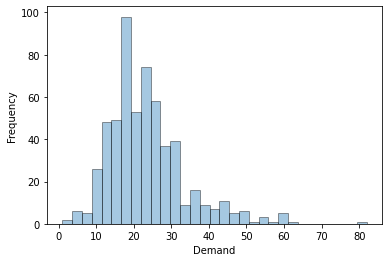

In [9]:
# plot a histogram 
sns.distplot(y_train, hist=True, norm_hist=False, kde=False,
             hist_kws={'edgecolor':'black'})

plt.ylabel('Frequency')
plt.xlabel('Demand')
plt.show(sns)

As we can see, it looks like the demand follows a normal distribution. We therefore estimate mean $\mu$ and standard deviation $\sigma$ to fit a normal distribution to the data

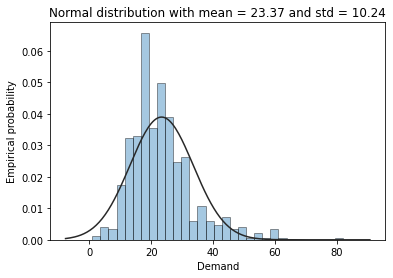

In [10]:
# determine mean and standard deviation
mean = round(y_train.mean(),2)
std = round(y_train.std(),2)

# plot histogram and fit a normal distribution to it
sns.distplot(y_train, hist=True, norm_hist=False, fit=norm, 
             kde=False, hist_kws={'edgecolor':'black'})

plt.ylabel('Empirical probability')
plt.xlabel('Demand')
plt.title("Normal distribution with mean = %.2f and std = %.2f" % (mean, std))

plt.show(sns)

In the next step, we can use this distribution to determine how many steaks to defrost overnight. But before that, we have to define the under- and overage costs for steak. The store manager tells us that each unit of unsold steak costs 5€ and each unit of demand that cannot be met costs 15€.

In [11]:
cu = 15
co = 5

Finally, we can implement equation (2), which then tells us how many steaks to defrost for a single day (the optimal inventory quantity $q$). 



In [12]:
# determine optimal inventory quantity
q = norm(mean,std).ppf(cu/(cu+co))[0]
round(q)

30.0

We call this the traditional parametric approach, we first assume the demand falls in a family of parametric distributions, estimate its parameters based on past demand samples, and then solve the initial optimization problem (2). 

To get a representation of the decision quality, we calculate the average costs over all days in the test set. For this, we use the `average_costs` function implemented in `ddop`. The function takes four arguments: the true values, the predicted values, the underage costs, and the overage costs.

In [13]:
# create array with length equal to number of observations in test set filled with the value of the inventory quantity q
y_pred = np.full(y_test.shape[0],q)

# calculate average costs
average_costs(y_true=y_test, y_pred=y_pred, cu=cu, co=co)

66.46472249886655

As you can see, we have average costs of 66.46€ associated with our decision. But can we do better? To answer this, let us go back to our data. So far we only used past steak demand samples. However, we have access to exogenous features that may have predictive power for demand, e.g. the weekday.  So next, we investigate whether the day of the week has an impact on demand. To do this, we determine mean and standard deviation for each weekday. 

In [14]:
# group demand by weekday
data = pd.concat([X_train, y_train], axis=1)
data_by_weekday = data.groupby("weekday")["steak"]

# determine mean and standard deviation for each weekday
mean_by_weekday = data_by_weekday.mean()
std_by_weekday = data_by_weekday.std()
d = {'Mean':mean_by_weekday, 'Std':std_by_weekday}
mean_and_std_by_weekday = pd.DataFrame(d).round(2)
mean_and_std_by_weekday

,Mean,Std
weekday,,
FRI,26.43,8.06
MON,18.79,7.44
SAT,37.80,12.21
SUN,16.55,6.08
THU,21.89,6.79
TUE,20.27,6.33
WED,21.80,6.54


We can clearly see that the demand varies greatly depending on the day of the week. We can clearly see that demand varies greatly depending on the day of the week. While the highest amount of steak is sold on Saturdays, the least amount is sold on Sundays and Mondays. One way to take this information into account is to fit a normal distribution for the samples of each weekday, respectively. As before, we can then use these distributions to determine the optimal inventory quantity by solving equation (2).

In [15]:
# determine decision q depending on the weekday
days = ['MON','TUE','WED','THU','FRI','SAT','SUN']
q_by_weekday = {}
for day in days:
  mean = mean_and_std_by_weekday.loc[day]['Mean']
  std = mean_and_std_by_weekday.loc[day]['Std']
  q_by_weekday[day] = round(norm(mean, std).ppf(cu/(cu+co)))
q_by_weekday

{'FRI': 32.0,
 'MON': 24.0,
 'SAT': 46.0,
 'SUN': 21.0,
 'THU': 26.0,
 'TUE': 25.0,
 'WED': 26.0}

Given the optimal decision for each weekday, we can write a simple predict function. 

In [16]:
def predict(X):
  """
  Get the decision for each sample in X depending on the weekday.

  Parameters
  ----------
  X : Pandas DataFrame of shape (n_samples, n_features)
      The input samples. 

  Returns
  ----------
  y : array of shape (n_samples,)
      The predicted values.
  """

  pred = [] 
  for index, sample in X.iterrows():
    day = sample['weekday']
    pred.append(q_by_weekday[day])

  return np.array(pred)

We apply the function to the test set and calculate the average costs. 

In [17]:
# predict optimal inventory quantity
y_pred = predict(X_test)

# calculate average costs
average_costs(y_test, y_pred, cu, co)

54.078947368421055

Now look, we were able to reduce the average costs from 66.46€ to 54.08€. That is a great improvement! But maybe we can do even better by considering the other features of the dataset as well. To do this, we could group observations with same feature values and then estimate a normal distribution for each group - like we did before but now with more features than just the weekday. However, this has two main drawbacks:
1. Imagine we have two features, the weekday and the month. If we were to estimate a distribution for each feature combination, we would have to fit a total of 7*12=84 distributions. That sounds like a lot of work, doesn't it?
2. To stay with the example: We consider the case where it is Monday and January. As you can see below, we only have 8 samples with the same feature values. Such a small number of samples makes it hard to fit a distribution. Moreover, with an increasing number of features we may not have a single sample with the same feature values.

In [18]:
X_train[(X_train['weekday']=='MON')&(X_train['month']=="JAN")].shape[0]

8

Instead of estimating a distribution for each group of samples with the same feature values, we can train a machine learning model to predict the demand. For example, we can use the `DecisionTreeRegressor` from `sklearn`. Note that we set the maximum depth of the tree to 10 to avoid overfitting. 

In [19]:
# predict demand using a regression tree
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(max_depth=10,random_state=1)
DT.fit(X_train_scaled,y_train)
pred = DT.predict(X_test_scaled)

Of course we cannot assume the model to be perfect: first, because of the model error itself, and second, because of the uncertainty in demand. For this reason, we need to adjust the predictions for uncertainty to obtain optimal decisions. We can get a representation of the remaining uncertainty by estimating the distribution of the prediction error on the training set. Assuming the error to be normally distributed, we determine the parameters $\mu_{e}$ and $\sigma_{e}$.

In [20]:
# determine mean and standard deviation of the prediction error
error = y_train["steak"]-DT.predict(X_train_scaled)
error_mean = error.mean()
error_std = error.std()

Next, we pass the error distribution to equation (2) to determine an additional safety buffer that adjusts the predictions based on the forecast error by balancing the expected overage and underage costs.

In [21]:
# determine safety buffer
safety_buffer = norm(error_mean, error_std).ppf(cu/(cu+co))

The final order decision is then the sum of both the prediction generated by our model and the safety buffer. More formally, the solution to the newsvendor problem can then be stated as:

\begin{equation}
q(x)^{*} = \mu(x)+\Phi^{-1}(\alpha),
\tag{3}
\end{equation}

where $\mu(\cdot)$ is the function of the machine-learning model that predicts the demand given feature vector $x$, and is $\Phi^{-1}$ the inverse cdf of the error distribution with parameter $\mu_{e}$ and $\sigma_{e}$. Consequently, in the next step, we add the safety buffer to the predictions to obtain optimal inventory quantities. 



In [22]:
# add safety buffer to the predictions of the model 
pred = pred + safety_buffer

Finally, we calculate the corresponding average costs.

In [23]:
# calculate average costs 
average_costs(y_test, pred, cu, co)

51.668449152885316

Again, we were able to reduce our average costs from 54.08€ to 51.67€. 

### Summary
Let us now summarize what we have learned so far:

* In case we do not know the demand distribution, we can estimate the distribution based on past demand samples and then solve equation (2) to determine the optimal inventory quantity.
* We can improve the decision by taking features into account. To do this, we group the data based on their feature values and estimate a distribution for each group. However, this does not work well for a large number of features.  
* Instead, we can use a machine-learning model to predict demand. Since we cannot assume the model to be perfect, we estimate the distribution of the prediction error to calculate an additional safety buffer. The optimal decision is then the sum of prediction and safety buffer.

## Data-Driven Approaches

So far we have only considered the traditional parametric way to solve the newsvendor problem. In this part of the tutorial, we introduce different **"data-driven"** approaches to solve the newsvendor problem. In contrast to the traditional way of first estimating the demand distribution and then solving the initial optimization problem, these approaches directly prescribe decisions from data.

### Sample Average Approximation

The simplest **data-driven** approach to solve the newsvendor problem is called **Sample Average Approximation (SAA)**. The idea behind **SAA** is to determine the optimal inventory quantity by finding the decision $q$ that minimizes the average cost on past demand samples. Formally, the optimization problem can be stated as follows: 

\begin{equation}q^{*}=\min _{q \geq 0} \frac{1}{n} \sum_{i=1}^{n}\left[c u\left(d_{i}-q\right)^{+}+c o\left(q-d_{i}\right)^{+}\right]
\tag{4}
\end{equation}

where $n$ is the total number of samples and $d_i$ is the i-th demand observation. Moreover, $(\cdot)^+$ is a function that returns $0$ if its argument is negative, and else its argument. Using this function we ensure that we multiply missing units by the underage costs and excess units by the overage costs. To fully understand how **SAA** works, we go through a simple example. 

**Example:** Determine how many steaks to defrost by applying **SAA**. The past demand for steak is given by: $D=[27,29,30]$. You can sell steak in your restaurant for 15€ (underage costs), while unsold units incur overage costs of 5€.

In the following, we try to minimize the optimization problem (4). For simplicity, we do not write down both terms $cu(d_i-q)^+$ and $co(q-d_i)^+$. One of them is always zero because we can have either underage units or overage units.

\begin{equation}
.....\\
q=27: \frac{1}{3}\Bigl[15*(27-27)+15*(29-27)+15*(30-27)\Bigl]=25\\
q=28: \frac{1}{3}\Bigl[5*(28-27)+15*(29-28)+15*(30-28)\Bigl]=16,67\\
q=29: \frac{1}{3}\Bigl[5*(29-27)+15*(29-29)+15*(30-29)\Bigl]=8,33\\
q=30: \frac{1}{3}\Bigl[5*(30-27)+5*(30-29)+15*(30-30)\Bigl]=6,67\\
q=31: \frac{1}{3}\Bigl[5*(31-27)+5*(31-29)+5*(31-30)\Bigl]=11,67\\
.....
\end{equation}

Based on our calculation, the optimal decision is given by $q=30$.

Now that we know how **SAA** works, we can apply the approach on the Yaz dataset by using the class `SampleAverageApproximationNewsvendor` from `ddop`. To initialize the model we pass the under- and overage costs to the constructor. Subsequently, we fit the model to the past demand samples and determine the optimal decision using the predict method.

In [24]:
SAA = SampleAverageApproximationNewsvendor(cu,co)
SAA.fit(y_train)
SAA.predict()

array([[28]])

Based on **SAA** the optimal decision is 28. To get a representation of the model performance, we use the model's `score` function. Just like the `average_costs` function, the `score` method calculates the average cost. The advantage is that we can directly calculate the costs without having to predict all training samples first.


In [25]:
-SAA.score(y_test)

60.23684210526316

With average cost of 60.24€, **SAA** performs better compared to the traditional parametric approach without features (66.46€). In contrast, **SAA** performs worse compared to the parametric approach with features (51.67€). However, this is not really surprising since we already know that exogenous features can improve decision making.

### Weighted Sample Average Approximation

Even though **SAA** is a common and effective approach, it only considers past demand samples. However, in the first part of the tutorial we have seen that we can improve our decision by taking into account features such as the weekday. We now want to do the same here by determining the optimal **SAA** decision for each weekday separately.

In [26]:
# determine q depending on the weekday using SAA
q_by_weekday = {}

SAA = SampleAverageApproximationNewsvendor(cu,co)

for day in days:
  demand = data_by_weekday.get_group(day)
  SAA.fit(demand)
  q_by_weekday[day] = SAA.predict().item(0)
 
print(q_by_weekday)

{'MON': 21, 'TUE': 24, 'WED': 26, 'THU': 26, 'FRI': 31, 'SAT': 45, 'SUN': 20}


Given the optimal decision for each day, we can write a new prediction function.

In [27]:
def predict(X):
  """
  Get the prediction for each sample in X depending on the weekday.

  Parameters
  ----------
  X : Pandas DataFrame of shape (n_samples, n_features)
      The input samples.

  Returns
  ----------
  y : array of shape (n_samples,)
      The predicted values.
  """

  pred = [] 
  for index, sample in X.iterrows():
    day = sample['weekday']
    pred.append(q_by_weekday[day])

  return np.array(pred)

We can then apply the function on the test set and calculate the average costs: 

In [28]:
pred = predict(X_test)
average_costs(y_test,pred,cu,co)

52.23684210526316

Again, we were able to reduce the average costs from 60.24€ to 52.24€ by taking into account the weekday. We can now go a step further by considering more features. To do this, we could use a separate model for the samples with the same feature values. However, as we have seen in the traditional parametric approach, this can become problematic when we have only a small number of samples with the same feature values. Another way to take feature information into account is to determine a weight for each sample based on the similarity to a new instance and optimize **SAA** against a re-weighting of the data. To determine the sample weights, we can use different machine learning techniques, such as a regression tree. For a better understanding, consider the following example.

**Example:** Say we have the following past demand samples with feature vector $x_i=(Weekend, Temperature)$ and we want to calculate their weights based on a new sample $x=(0,18)$.

| Sample| Weekend | Temperature [in °C] | Demand |
|:-:|:-:|:--:|:--:|
| 1| 0 | 19 | 27 |
| 2| 1 | 25 | 29 |
| 3| 1 | 23 | 30 |
| 4| 0 | 25 | 18 |
| 5| 0 | 24 | 20 |
| 6| 0 | 22 | 23 |
| 7| 0 | 11 | 21 |

First, we train a regression tree to predict the demand given the features weekday and temperature. The resulting tree looks like this:

<img src="https://drive.google.com/uc?export=view&id=1fXW6PV2bUcnZSNByTde39k8hEgRB_5aV" width="450" align="center">

The regression tree splits our data into four leafs based on the two features. 
To determine the sample weights, we look to which leaf the new instance $x=(0,18)$ belongs. In the first level of the tree we follow the left path since it is no weekend. Then, given the temperature forecast of $18°C$, we end up in leaf 1 together with sample 1, 6, 7. This means that these observations are most similar to $x$. Using this information, we assign a weight of $\frac{1}{3}$ to each of the three samples falling into the same leaf. The sample weights are then given by:

\begin{equation}
w_1=\frac{1}{3},\:w_2=0,\:w_3=0,\:w_4=0,\:w_5=0,\:w_6=\frac{1}{3},\:w_7=\frac{1}{3}
\end{equation}


Now that we have calculated the sample weights, we can solve the optimization problem like before. The only difference is that we multiply each observation with its corresponding weight, which indicates the similarity to the new sample.   

\begin{equation}
q=18: \frac{1}{3}\bigl[15*(27-18)\bigl]+...+\frac{1}{3}\bigl[15*(23-18)\bigl]+\frac{1}{3}\bigl[15*(21-18)\bigl] = 85\\
......\\
q=26: \frac{1}{3}\bigl[15*(27-26)\bigl]+...+\frac{1}{3}\bigl[5*(26-23)\bigl]+\frac{1}{3}\bigl[5*(26-21)\bigl] = 18.33\\ 
q=27: \frac{1}{3}\bigl[15*(27-27)\bigl]+...+\frac{1}{3}\bigl[5*(27-23)\bigl]+\frac{1}{3}\bigl[5*(27-21)\bigl] = 16.67\\ 
q=28: \frac{1}{3}\bigl[5*(28-27)\bigl]+...+\frac{1}{3}\bigl[5*(28-23)\bigl]+\frac{1}{3}\bigl[5*(28-21)\bigl] = 21.67\\
......\\
q=30: \frac{1}{3}\bigl[5*(30-27)\bigl]+...+\frac{1}{3}\bigl[5*(30-23)\bigl]+\frac{1}{3}\bigl[5*(30-21)\bigl] = 30.67 
\end{equation}

Based on our calculation, $q=27$ is the quantity  minimizing the average costs on the weighted samples. 

We call this approach **"weigthed Sample Average Approximation (wSAA)"** as it can be seen as weighted form of **SAA**. More formally the problem can be stated as follows:  

\begin{equation}
q(x)^*=\min_{q\geq 0} \sum_{i=1}^{n}w_i(x)\bigl[cu(d_i-q)^+ + co(q-d_i)\bigl],
\tag{5}
\end{equation}

where $x$ is the feature vector of a new instance and $w_i(\cdot)$ is a function that assigns a weight $w_i\in [0,1]$ to each past demand sample $S_i(x_i,d_i)$ based on the similarity of $x$ and $x_i$. In the example above we used a weight function based on a decision tree (DT), given by:

\begin{equation}
w_{i}^{Tree}(x)=\frac{\mathbb{1}x_i \in R(x)}{N(x)},
\end{equation}

where $\mathbb{1}$ is the indicator function, $R(x)$ is the leaf containing $x$, and $N(x)$ is the number of samples falling into leaf $R(x)$. In other words, the function will give a weight of $\frac{1}{N(x)}$ to sample $i$ if $x_i$ belongs to the same leaf as the new instance $x$, and otherwise zero.

Instead of using a DT, we can also use other machine learning methods to determine the sample weights, for example k-nearest-neighbors (kNN):

\begin{equation}
w_{i}^{k \mathrm{NN}}(x)=\frac{1}{k} \mathbb{1}\left[x_i \text { is a } k \mathrm{NN} \text { of } x\right],
\end{equation}

where $k$ is the number of neighbors. In simple terms, the function will give a weight of $\frac{1}{k}$ to sample $x_i$ if it is a k-nearest-neighbor of $x$.

We can apply these approaches on our dataset by using the class `RandomForestWeightedNewsvendor` and `KNeighborsWeightedNewsvendor` from `ddop`. To initialize the models, we pass the overage- and underage costs to the constructor. Moreover, we define some addition model-specific parameters. For instance, we set the maximum depth for `DecisionTreeWeightedNewsvendor` to $8$ and the number of neighbors for `KNeighborsWeightedNewsvendor` to $30$. After we have initialized our models we fit them on the training data and calculate the average costs on the test set by using the `score` function:

In [29]:
DTW = DecisionTreeWeightedNewsvendor(cu=cu, co=co, max_depth=8,random_state=1)
DTW.fit(X_train_scaled, y_train["steak"])
DTW_score = DTW.score(X_test_scaled,y_test)
print("Avg. cost DTW: ",-DTW_score)

kNNW = KNeighborsWeightedNewsvendor(cu=cu, co=co, n_neighbors=30)
kNNW.fit(X_train_scaled, y_train)
kNNW_score = kNNW.score(X_test_scaled,y_test)
print("Avg. cost kNNW: ", -kNNW_score)


Avg. cost DTW:  47.6578947368421
Avg. cost kNNW:  47.473684210526315


These are the best results so far. Both models, **DTW** (47.66€) and **kNNW** (47.47€), outperform all other models we have seen so far. 

-----------------------------------------------------

### Empirical Risk Minimization

With **wSAA** we have already learned a data-driven approach that is able take exogenous features into account. However, to obtain a decision $q$, we have to first determine weights and then solve an optimization problem for every new sample $x$. But wouldn't it be great to learn a function that instead maps directly from features $x\in X$ to a decision $q\in Q$? A natural way to obtain such a function is though [empirical risk minimization](https://en.wikipedia.org/wiki/Empirical_risk_minimization):
\begin{equation}
\min_{q(\cdot)\in\mathcal{F}} \frac{1}{n}\sum_{i=1}^{n}\bigl[cu(d_i-q(x_i))^+ + co(q(x_i)-d_i)^+\bigl],
\tag{6}
\end{equation}


where $q(\cdot)$ is the function that maps from feature space $X$ to decision space $Q$, and $\mathcal{F}$ is its function class. Again, $x_i$ is the feature vector of the i-th sample, and $d_i$ is the corresponding demand value. To say it simple, we try to find the function $q(\cdot):X\rightarrow Q$ that minimizes the average costs on $n$ past demand samples (the empirical risk). The most straightforward way to do this is based on linear regression.

#### Linear Regression

Suppose we have only a single feature, say temperature, and given the value for the temperature we want to know how many steaks to defrost.  In other words, we want to find a function $q(temp)$ that maps from temperature to a decision $q$. Of course, the first thing we need to do is  to collect some data.  

| Sample| Temperature [in °C] | Demand |
|:-:|:-:|:--:|
| 1| 5 | 16 |
| 2| 7 | 12 |
| 3| 10 | 14 |
| 4| 12 | 10 |
| 5| 15 | 11 |
| 6| 18 | 7 |
| 7| 20 | 9 |
| 8| 21 | 6 |
| 9| 23 | 8 |
| 10| 25 | 4 |

We plot the data and it looks like there is a linear relationship between temperature and demand (see figure below). Consequently, to solve our problem the first thing that comes into mind is linear regression. For this reason, we construct a linear function $q(temp)=b+w*temp$, where $b$ is the intercept term, and $w$ is a weight. We can think of the intercept as a base demand to which we add or subtract a certain amount depending on the temperature and weight $w$. To find the optimal mapping from temperature to demand, we now have to learn the best fitting values for $b$ and $w$. We start by setting $b=16$ and $w=-0,4$, which gives us function $q(temp)=16-0,4*temp$ that already fits the data quite well. Still, for each sample $i$ we obtain an error representing the difference between the actual demand $d_i$ and the estimated decision of $q(temp_i)$. In the figure below these errors are illustrated as dotted lines. 

<img src="https://drive.google.com/uc?export=view&id=1IbPX_WRmSURbEypcyYdwwcvSo7aUjfDZ" width="600" align="center">

According to linear regression, the goal would be to adjust the values for $b$ and $w$ in a way that minimizes the mean difference (error) between the actual demand and the estimated decision. Formally speaking:

\begin{equation}
\min_{b,w} \frac{1}{n}\sum_{i=1}^{n}\Bigl(d_i-(b+w*temp)\Bigl)^2
\end{equation}

In our case, however, this can be problematic because overage would have the same effect as underage. Now recall that each unit of unsold steak costs 5€, while each unit of demand that cannot be satisfied costs 15€. In other words, one unit too little costs three times more than one unit too much. Consequently, we minimize the average cost rather than the mean difference. The resulting optimization problem is then given by:

\begin{equation}
\min_{b,w} \frac{1}{n}\sum_{i=1}^{n}\bigl[cu(d_i-(b+w*temp))^+ + co((b+w*temp)-d_i)^+\bigl]
\end{equation}

Doesn't this look like equation $(6)$, which we introduced at the very beginning of this chapter? The only difference is that we have defined $q(\cdot)$ as a linear decision function of the form $q(temp)=b+w*temp$. To solve this optimization problem, we can use the class `LinearRegressionNewsvendor` from `ddop`.

In [30]:
temp = [[5],[7],[10],[12],[15],[18],[20],[21],[23],[25]]
demand = [16,12,14,10,11,7,9,6,8,4]
mdl = LinearRegressionNewsvendor(cu=15,co=5)
mdl.fit(X=temp,y=demand)

LinearRegressionNewsvendor(co=5, cu=15)

After fitting the model, we can access the intercept term $b$ via the argument `intercept_` and the weight $w$ via the argument `feature_weights_`. 

In [31]:
print("b:",mdl.intercept_)
print("w:",mdl.feature_weights_)

b: [18.333333]
w: [[-0.46666667]]


Thus, the function $q(\cdot)$ that fits our data best is given by:

\begin{equation}
q(temp)=18.3-0.47*temp
\end{equation}

In the next step we want to know how many steaks to defrost for tomorrow. We check the weather forecast, which tells us that it will be 25 degrees. Given the temperature, the function $q(\cdot)$ then tells us that the optimal inventory stock is: $18.3-0.47*10=13.6$. Instead of determining the decision ourselves, we can also use the model's ´predict` method:

In [32]:
mdl.predict([[10]])

array([[13.6666663]])

Of course, this was just a simple example to illustrate the concept of this approach. As we know, the Yaz dataset provides a lot more features than just the temperature. Consequently, we are looking for a function of the form:



\begin{equation}
q(x)=b+w_1*x_1+...+w_m*x_m=b+\sum_{j=1}^{m}w_j*x_j,
\tag{7}
\end{equation}

where $x_j$ represents the value of feature $j$-th from sample $x$, and $w_j$ is the corresponding feature weight. As a result, the optimization problem that we want to solve becomes:

\begin{equation}
\min_{b,w_1,..,w_m} \frac{1}{n}\sum_{i=1}^{n}\bigl[cu(d_i-b-\sum_{j=1}^{m}w_j*x_{i,j})^+ + co(b+\sum_{j=1}^{m}w_j*x_{i,j}-d_i)^+\bigl],
\tag{8}
\end{equation}

We now have to learn the value for intercept term $b$ and feature weights $w_1,...,w_m$. For now, we do this just for the temperature and the weekdays. Note that we use the one hot encoded version of the data, thus each weekday is represented by a binary column. 

In [33]:
cols = ['temperature', 'weekday_MON', 'weekday_TUE', 'weekday_WED', 'weekday_THU', 'weekday_FRI', 'weekday_SAT', 'weekday_SUN']
LRN = LinearRegressionNewsvendor(cu=15,co=5)
LRN.fit(X_train_encoded[cols],y_train)
print(LRN.intercept_)
print(LRN.feature_weights_)

[24.860215]
[[-0.21505376  0.          2.2580645   3.7311828   2.9032258   8.3978495
  22.225806   -1.5913978 ]]


We note that the intercept term is 24.86. This is now our base demand to which we add or subtract a certain amount, depending on corresponding feature values. For example, we add 22.23 for a Saturday. In contrast, we subtract 1.59 for a Sunday. The weight for the temperature is -0.215 so we would subtract 2.15 in case it is 10°C. At this point it should be clear how this approach works and how the parameters are to be interpreted. So in the next step, we can now apply the model to our dataset. 


In [39]:
LRN = LinearRegressionNewsvendor(cu=15,co=5)
LRN.fit(X_train_encoded,y_train)
-LRN.score(X_test_encoded,y_test)

48.932357245389476

With average costs of €48.93 the model performs slightly worse compared to the **wSAA** approaches. However, it outperforms all other models we have seen so far.

#### Deep Learning

In the previous section, we assumed that the demand is a linear combination of features. To find the perfect mapping from features $x$ to decision $q$ we therefore specified that $q(\cdot)$ belongs to the class of linear decision functions. However, sometimes there is no linear relationship, so we need a nonlinear function to describe our data. One way to obtain such a function is by using a deep neural network (DNN).

<img src="https://drive.google.com/uc?export=view&id=1rmgdo9urd4Qx5MQrPu4sO9sto8_ogCm1" align="center">

A DNN uses a cascade of many layers to obtain an output given some input data. In general, it can be distinguished between input-, hidden-, and output-layer, each consisting of a number of neurons. In the first layer the number of neurons corresponds to the number of inputs. In other words, each neuron takes the value of a single feature as input, e.g. the temperature or the weekday. The input-layer is followed by a number of hidden-layers, each presented by an arbitrary number of neurons. In the output-layer the number of neurons corresponds to the number of outputs. In our example, we only have a single neuron that outputs the decision $q$ conditional on the features temperature and weekday. The individual neurons of a layer are each connected to the neurons of the layer before and behind. In a graph, the neurons can be represented as nodes and their connections as weighted edges. A neuron takes the outputs of the neurons from the previous layer as inputs. Subsequently, it computes the weighted sum of its inputs and adds a bias to it. Formally speaking:

\begin{equation}
bias+\sum_{l=1}^{L}x_l*w_l, 
\tag{9}
\end{equation}

where $x_l$ is the $l$-th input of a neuron and $w_l$ the corresponding weight. Does this look familiar? This is the exactly the decision function $(7)$ that we used in the regression based approach before. The only difference is that we use the term "bias" for the constant value instead of "intercept". But what does this mean? If we were just to combine a set of linear functions, we would get a single linear function as a result. In other words, there would be no difference to the previous approach. This is where the activation function comes into play. The activation function is a non-linear function that transforms the computed value of equation (9) and then outputs the final result of a neuron. For example, the Rectified Linear Unit (ReLU) activation function outputs $0$ if the input value is negative and its input otherwise. Thus, the DNN models a piecewise linear function, which may looks like this:

<img src="https://drive.google.com/uc?export=view&id=18YRxB6jYlqV97FaEPXf-IcRuJt1nWkWI"  width="350" align="center">

The goal of the network is then to find the function that fits the data best. To find such a function in the linear regression based model, we had to determine the optimal values for the feature weights and the intercept term. This is basically the same here. We just have a lot more weights and intercept terms (biases). Since we are trying to obtain cost-optimal decisions, the network tries to determine the unknown parameters in a way that minimizes the average costs on our data.  Thus, the problem can be stated as follows:  

\begin{equation}
\min_{w,b} \frac{1}{n}\sum_{i=1}^{n}\bigl[cu(d_i-\theta(x_i;w,b))^+ + co(\theta(x_i;w,b)-d_i)^+\bigl],
\tag{10}
\end{equation}

where $\theta(\cdot)$ represents the function of the network with weights $w$ and biases $b$. Now look, this is again similar to equation $(6)$. The only difference is that $q(\cdot)$ is represented by a DNN. 

To apply this approach on the Yaz dataset we can use the class `DeepLearningNewsvendor` from `ddop`.

In [48]:
DLN = DeepLearningNewsvendor(cu=15,co=5)
DLN.fit(X_train_scaled,y_train)
-DLN.score(X_test_scaled,y_test)

49.17223325528597

As we can see, the average cost are higher compared to both the linear regression based model and the WSAA models. One reason for this might be that a neural network often needs more data to learn a good decision function.

### Summary

In this part of the tutorial we have seen three different data-driven approaches to solve the newsvendor problem. 

* In the simplest case where we only have past demand observations we can use sample average approximation **(SAA)** to solve the newsvendor problem. The goal of **SAA** is to find the decision $q$ that minimizes the average costs on past demand samples.
* However, we have seen that additional demand features can improve decision making, since they usually reduce the degree of uncertainty.
* With weighted sample average approximation **(wSAA)** and empirical risk minimization **(ERM)** we got to know two data-driven approaches that can take such features into account by learning a function $q(\cdot)$ that maps from features $x$ to a decision $q$. 
* **wSAA**, on the one hand, defines the function $q(\cdot)$ point-wise. It is based on deriving sample weights from features and optimizing **SAA** against a re-weighting of the training data. To determine the weights we can use different weight functions, e.g., based on KNN or DT regression. 
* The **ERM** approach, on the other hand, tries to find the function $q(\cdot)$ that maps from features to a decision by minimizing its empirical risk. Therefore, we have to specify the function space to which the decision function belongs. With `LinearRegressionNewsvendor`, and `DeepLearningNewsvendor` we have seen two models that define $q(\cdot)$ in a different manner. While the former one assumes that $q(\cdot)$ is a linear decision function, the latter one defines $q(\cdot)$ as non-linear function by using as a deep neural network.

## A Final Note

In this tutorial, you learned how to solve the newsvendor problem based on past demand data. For the specific case of Yaz and the data for the product "steak", you have seen that several data-driven algorithms can outperform the traditional parametric approach. The best method has been shown to be **wSAA** with a weight function based on k-nearest-neighbors regression. However, it is important to note that there is no such thing as "the best model". Which model performs best can vary from one task to another. It may depend on the cost parameters, the number of features or the size of the dataset. This is exactly the reason why `ddop` provides easy access to a set of different models that can be used to find the best one for a given problem. As a next step, you can now build up on what you have learned and apply the different algorithms to some other data. For example, you can start by using the data for a product other than "steak", or even several products at once. Alternatively, you can use the bakery dataset that is also provided within `ddop`.
